# Book Recognition From JPEG Image

I have a lot of books.  So many that sometimes I end up acquiring books that I already own.  A simple solution to this problem would be to create a list of books in the library and consult the list when needed.  I thought, "No, that's too easy!  Why not take a picture of the books cover, recogize the text, and then match the recognition with such a list."  So that started this little project in image OCR (Optical Character Recognition).

In [ ]:
# imports
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (100,100)

import matplotlib.pyplot as plt
import numpy as np
from skimage import io, data, segmentation, util, exposure
from skimage.color import rgb2gray, label2rgb, gray2rgb
from skimage.filters import sobel, scharr
from skimage.segmentation import felzenszwalb
from skimage.future import graph
from skimage.measure import label, regionprops
import pytesseract
from difflib import SequenceMatcher

In [1]:
# A list of books in the library
books = ["Probabilistic Approaches To Design EDWARD B HAGEN",
        "JavaScript The Definitive Guide O'REILLY David Flanagan",
        "Oliver Byrne THE FIRST SIX BOOKS OF THE ELEMENTS OF EUCLID TASCHEN",
        "X AND THE CITY JOHN A. ADAM"]

To try to make the algorithm somewhat more robust I decided to use 2 (count them...2) different book images so that I didn't overfit a single test image.

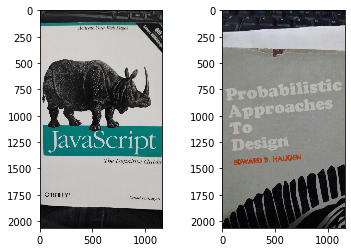

In [3]:
# Read in the image
# change this to try other images
img = io.imread('book-jstdg3.jpeg')
img2 = io.imread('book-patd2.jpeg')
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img2)
plt.show()

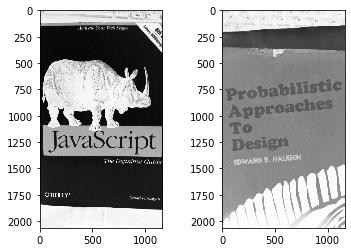

In [4]:
# convert to grayscale image
img_gray = rgb2gray(img)
img2_gray = rgb2gray(img2)
plt.subplot(121)
plt.imshow(img_gray, cmap="Greys")
plt.subplot(122)
plt.imshow(img2_gray, cmap="Greys")
plt.show()

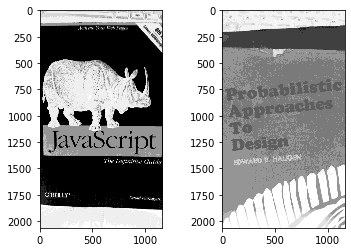

array([[0.2, 0.2, 0.2, ..., 0.1, 0.1, 0.1],
       [0.2, 0.2, 0.2, ..., 0.1, 0.1, 0.1],
       [0.2, 0.2, 0.2, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

In [5]:
# reduce the number of grays to 10 by rounding
img_gray2 = np.round(img_gray, 1)
img2_gray2 = np.round(img2_gray, 1)
plt.subplot(121)
plt.imshow(img_gray2, cmap="Greys")
plt.subplot(122)
plt.imshow(img2_gray2, cmap="Greys")
plt.show()
img_gray2

In [6]:
# We are interested in segmenting the image such that we can 
# possibly recognize the characters in the image.  Let us simply 
# label the image based on gray scale


img_labels = label(img_gray2.astype(int))
img2_labels = label(img2_gray2.astype(int))
img_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

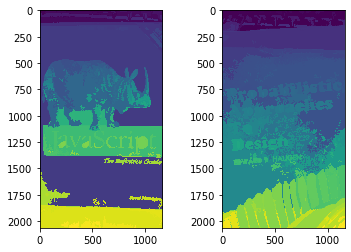

In [7]:
# We will compare with an initial felzenszalb segmentation
#from skimage.segmentation import felzenszwalb
    
segments = felzenszwalb(img_gray2, scale=0.9, sigma=0.2, min_size=300)
#segments2 = felzenszwalb(img2_gray2, scale=1.0, sigma=0.0, min_size=300)
segments2 = felzenszwalb(img2_gray2, scale=0.9, sigma=0.2, min_size=300)
plt.subplot(121)
plt.imshow(segments)
plt.subplot(122)
plt.imshow(segments2)
plt.show()

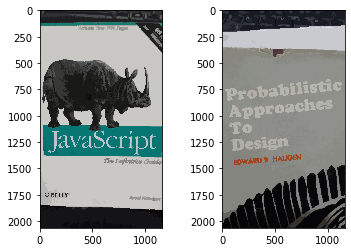

In [8]:
# RAG using boundary better than mean color

#from skimage.future import graph
#from skimage import data, segmentation, color, filters, io
#from matplotlib import pyplot as plt

gimg = img_gray2
gimg2 = img2_gray2

labels = segments
labels2 = segments2
labels3 = img_labels
labels4 = img2_labels

edges = scharr(gimg)
edges2 = scharr(gimg2)

g = graph.rag_boundary(labels, edges)
g2 = graph.rag_boundary(labels2, edges2)
#g3 = graph.rag_boundary(labels3, edges)
labels_cut = graph.cut_threshold(labels, g, 0.01)
labels_cut2 = graph.cut_threshold(labels2, g2, 0.01)
#labels_cut3 = graph.cut_threshold(labels3, g3, 0.01)
out_cut = label2rgb(labels_cut, img, kind='avg')
out_cut2 = label2rgb(labels_cut2, img2, kind='avg')
#out_cut3 = label2rgb(labels_cut3, img, kind='avg')

plt.subplot(121)
plt.imshow(out_cut)
plt.subplot(122)
plt.imshow(out_cut2)
plt.show()

For the rest, only a single image will be processed.  You can change the commented lines to run either image.

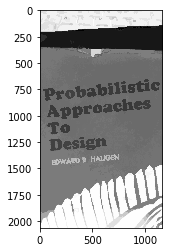

In [9]:
#out4 = rgb2gray(out_cut)
out4 = rgb2gray(out_cut2)
plt.imshow(out4, cmap="Greys")
plt.show()

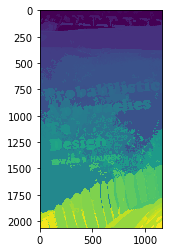

In [10]:
# do it all again on the now, cleaner data
segments2 = felzenszwalb(out4, scale=1.0, sigma=0.0, min_size=300)
plt.imshow(segments2)
plt.show()

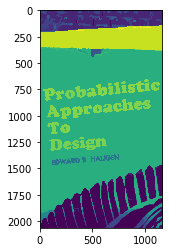

In [11]:
# now do mean color RAG
img4 = out4

labels1 = segments2

g = graph.rag_mean_color(img4, labels1)
labels2 = graph.cut_threshold(labels1, g, 0.08)
out5 = label2rgb(labels2, img4, kind='avg')

plt.imshow(out5)
plt.show()

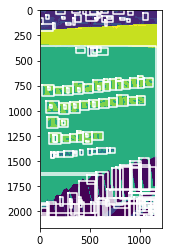

In [12]:
# plot the bounding boxes 
def plot_bounding_boxes(image, labels):
    #labels = label(image)
    props = regionprops(labels, image)
    
    #plt.ylim(-1,2300)
    plt.imshow(image)
    for prop in props:
        if prop.area > 300:
            #print(prop.bbox)
            minr, minc, maxr, maxc = prop['BoundingBox']
            ratio = (maxc - minc)/(maxr - minr)
            if ratio < 3 and ratio > 0.3:
                bx = (minc, maxc, maxc, minc, minc)
                by = (minr, minr, maxr, maxr, minr)
                plt.plot(bx, by, '-w', linewidth=1.5)
        
    plt.show()
    return labels, props

out5_labels, out5_props = plot_bounding_boxes(out5, labels2)

I originally thought this would be the time to train a tensorflow model on character data and attempt to do the character recognition from that model but why reinvent the wheel when tesseract is out there.  A better, modern, and much slower program is easyOCR with a 280MB model that takes about 30mins to run.

In [13]:
# Let's look at the detected strings
image_string = []
custom_config = r'--oem 1 --psm 11'
for box in out5_props:
    image_string.append(pytesseract.image_to_string(box.image, config=custom_config))
image_string

['7 7 M/S Te\n\n"yy\n\nfe) he',
 '',
 '',
 '',
 'a',
 '',
 '',
 'ae\n\nos',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'i\n\nOM',
 '',
 '.',
 '',
 '',
 '|',
 'vo',
 '',
 'Sa it ea\n\nttl’',
 'P|',
 '_-',
 '',
 '',
 '',
 'a\n\nes',
 '',
 '—\n\nNTO Iie\n\neet et',
 '',
 '',
 '',
 '',
 '',
 '',
 'Prevabilistic\n\nAppreacnes\n\nTe\n\nDesign\n\nEDWARD B HAUGEN\n\naati',
 '',
 '',
 '',
 'L',
 '',
 '',
 '',
 'ag',
 '',
 '—',
 'Lg\n\nr',
 ')',
 '',
 'oa\n\nF',
 'Ne',
 'p',
 ')',
 'lv',
 ')\n\n-',
 '',
 '.',
 '',
 ',',
 'S',
 'py',
 '',
 '%',
 'h',
 'Ne',
 '',
 'Ly',
 'oa',
 'S\n\ny\n\n\\\n\n.',
 '',
 ') yy',
 ', CN\n\nyp',
 '',
 'PF',
 'o',
 'S',
 '',
 '4 \\\n\nP|',
 'a\n\ny\n\nF',
 '|',
 'PG\n\n—',
 'y',
 'r\n\n4 |',
 'sv',
 'yf',
 'he',
 ',\n\neo',
 '',
 'ow',
 '5',
 'Ug',
 'Ne',
 '<',
 'UKs',
 '',
 'g |',
 '5',
 '|\n\nv',
 'AR',
 'W',
 'sy',
 '>',
 '',
 'S',
 '|',
 '',
 '|',
 't',
 '',
 '',
 '\\',
 '',
 '',
 '|',
 '',
 '',
 '4',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '\\',
 '',
 '

Now do some fuzzy string matching and print the highest score.  Hopefully this will be the book in the starting image.

In [14]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

max_score = 0
best_book = ''
for book in books:
    for s in image_string:
        if len(s) > 6:
            s1 = s.split('\n')
            s2 = ' '.join(s1)
            score = similar(s2, book)
            if score > max_score:
                max_score = score
                best_book = book
print(round(max_score, 3), best_book)

0.807 Probabilistic Approaches To Design EDWARD B HAGEN


And there you have it.  A book properly detected from the JPEG image.